<a href="https://colab.research.google.com/github/dajebbar/Arthropod-Taxonomy-Order-Detection/blob/main/arthropod_taxonomy_order_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arthropod Taxonomy Orders Object Detection
---
Invertebrate animal (arthropod) images annotated for object detection

The [dataset](https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-dataset) consists of images of arthropods in jpeg format and object boundary boxes in json format. There are between one and 50 objects per image.

This dataset is actively maintained, and new orders will be added on a regular basis. Currently, the following orders are covered with at least 2000 objects per order:

- Araneae (spiders), adults, juveniles
- Coleoptera (beetles), adults
- Diptera (true flies, including mosquitoes, midges, crane file etc.), adults
- Hemiptera (true bugs, including aphids, cicadas, planthoppers, shield bugs etc.), adults and nymphs
- Hymenoptera (ants, bees, wasps), adults
- Lepidoptera (butterflies, moths), adults
- Odonata (dragonflies, damselflies), adults

### Download the dataset from kaggle
Using opendatasets and download the [dataset](https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-dataset)

In [1]:
!pip install opendatasets --upgrade --quiet

In [12]:
import opendatasets as od

url = 'https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-dataset'

od.download(url)

  0%|          | 5.00M/11.1G [00:00<06:00, 33.1MB/s]

100%|██████████| 11.1G/11.1G [04:28<00:00, 44.5MB/s]


In [13]:
import os

data_dir = './arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr'

os.listdir(data_dir)

['Hymenoptera',
 'Araneae',
 'ArTaxOr.png',
 'Odonata',
 'revision history.txt',
 'license.txt',
 'Lepidoptera',
 'readme.txt',
 'Diptera',
 'Coleoptera',
 'Hemiptera']

We notice that there are files that we can delete `revision history.txt` or `ArTaxOr.png`

In [25]:
to_del = ['ArTaxOr.png','revision history.txt', 'license.txt', 'readme.txt']

for file in to_del:
  os.remove(data_dir + '/' +file)

os.listdir(data_dir)

['Hymenoptera',
 'Araneae',
 'Odonata',
 'Lepidoptera',
 'Diptera',
 'Coleoptera',
 'Hemiptera']

We also notice that each class contains a file named "annotations". Let's delete it.

In [26]:
import shutil

for cls in os.listdir(data_dir):
  shutil.rmtree(data_dir + '/' + cls + '/annotations')

The number of images per classes

In [27]:
for cls in os.listdir(data_dir):
  print(f"{cls}: {len(os.listdir(data_dir + '/' + cls))}")

Hymenoptera: 2048
Araneae: 2418
Odonata: 2277
Lepidoptera: 2106
Diptera: 2030
Coleoptera: 2110
Hemiptera: 2387


## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [28]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(data_dir)

In [29]:
len(dataset)

15376

In [30]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=1100x1588 at 0x7FA3775E7150>, 0)

In [31]:
dataset.classes

['Araneae',
 'Coleoptera',
 'Diptera',
 'Hemiptera',
 'Hymenoptera',
 'Lepidoptera',
 'Odonata']

In [32]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

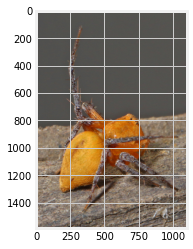

In [33]:
img, _ = dataset[0]
plt.imshow(img)

In [34]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

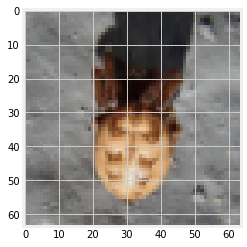

In [35]:
img, _ = dataset[1070]
plt.imshow(img.permute(1,2,0))

In [36]:
val_pct = .2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(12301, 3075)

In [37]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(12301, 3075)

In [38]:
from torch.utils.data import  DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [39]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

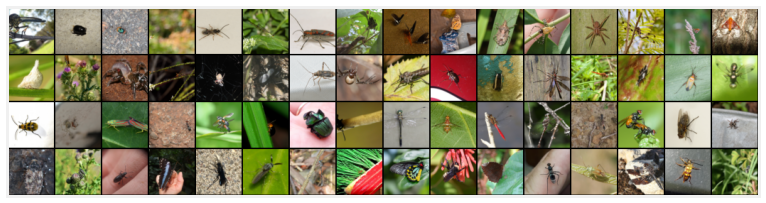

In [40]:
show_batch(train_dl)

## GPU Utilities

In [41]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
images, labels = dataset[0]

In [44]:
images.device

device(type='cpu')

In [45]:
img_gpu = to_device(images, device)
img_gpu.device

device(type='cuda', index=0)

In [46]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [47]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [48]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [49]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [50]:
model = to_device(ResNet9(3, len(dataset.classes)), device)

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Pass one batch of input tensor through the model

In [51]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print('images.shape ', images.shape)
  print('images.device ', images.device)

  preds = model(images)

  print('preds.shape ', preds.shape)
  # print('preds ', preds)
  break

images.shape  torch.Size([64, 3, 64, 64])
images.device  cuda:0
preds.shape  torch.Size([64, 7])


## Training

In [52]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.15625, 'val_loss': 1.9447073936462402}]

In [53]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 2.0852, val_loss: 1.8846, val_acc: 0.2558
Epoch [1], train_loss: 1.9110, val_loss: 1.8344, val_acc: 0.2747
Epoch [2], train_loss: 1.8499, val_loss: 1.8976, val_acc: 0.2778
Epoch [3], train_loss: 1.7751, val_loss: 1.8028, val_acc: 0.3107
Epoch [4], train_loss: 1.7197, val_loss: 2.0066, val_acc: 0.2538


In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

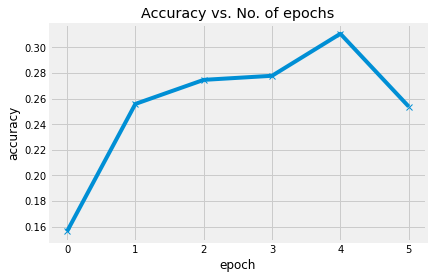

In [55]:
plot_accuracies(history)

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

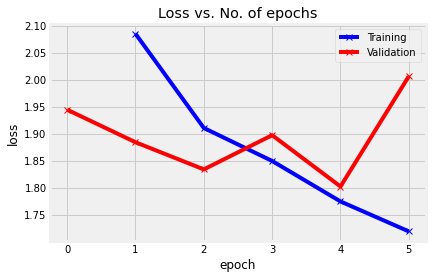

In [57]:
plot_losses(history)

### Test with individual images

In [58]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [59]:
def show_img(img, label):

  plt.imshow(img.permute(1,2,0))

  target = dataset.classes[label]
  pred = predict_image(img, model, dataset.classes)
  
  print('target label: ', target)
  print('predict label: ', pred)

target label:  Diptera
predict label:  Odonata


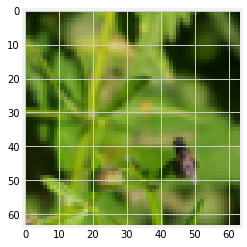

In [60]:
show_img(*val_ds[0])

target label:  Diptera
predict label:  Lepidoptera


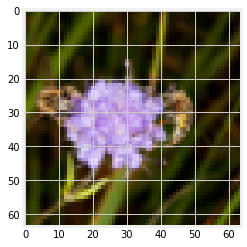

In [61]:
show_img(*val_ds[1030])

target label:  Diptera
predict label:  Odonata


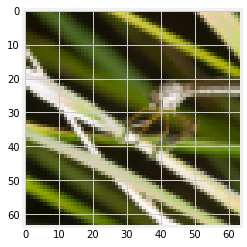

In [62]:
show_img(*val_ds[19])

### Save the Model

In [63]:
torch.save(model.state_dict(), 'flowers-recognition-resnet9.pth')

## Transfer Learning

In [64]:
from torchvision import models

class ResNetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [65]:
model = to_device(ResNetModel(len(dataset.classes), pretrained=True), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### Recreate the dataset

In [66]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [67]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(12301, 3075)

In [68]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [69]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [70]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [71]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.1853741556406021, 'val_loss': 2.087167739868164}]

In [72]:
history += fit_one_cycle(6, 0.0001, model, 
              train_dl, val_dl,
              weight_decay=0.01, grad_clip=0.1,opt_func=torch.optim.Adam)


Epoch [0], train_loss: 1.3006, val_loss: 0.7111, val_acc: 0.7521



Epoch [1], train_loss: 0.6230, val_loss: 0.8667, val_acc: 0.7045



Epoch [2], train_loss: 0.3723, val_loss: 0.6878, val_acc: 0.7726



Epoch [3], train_loss: 0.1822, val_loss: 0.6298, val_acc: 0.8009



Epoch [4], train_loss: 0.0747, val_loss: 0.6128, val_acc: 0.8232



Epoch [5], train_loss: 0.0343, val_loss: 0.6083, val_acc: 0.8264


## Visualization

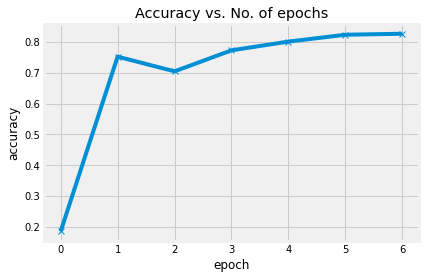

In [73]:
plot_accuracies(history)

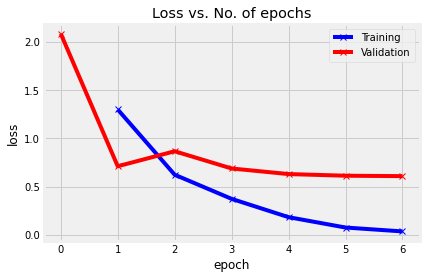

In [74]:
plot_losses(history)

In [75]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

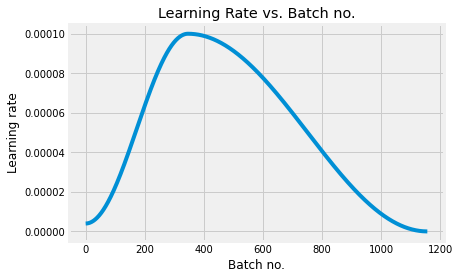

In [76]:
plot_lrs(history)

### Test with individual images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target label:  Araneae
predict label:  Araneae


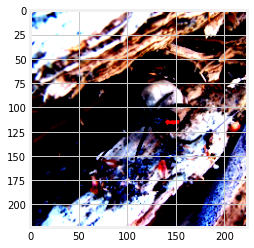

In [77]:
show_img(*val_ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target label:  Lepidoptera
predict label:  Lepidoptera


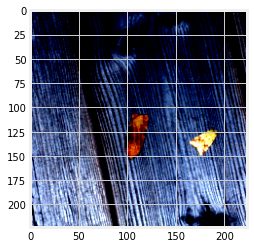

In [78]:
show_img(*val_ds[1030])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target label:  Araneae
predict label:  Araneae


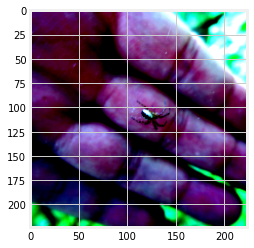

In [79]:
show_img(*val_ds[19])